In [ ]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## End to end TCR Valid clustering, cluster identification and latent dimension interpretability exploration

In [77]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import manhattan_distances
from tcrvalid.load_models import *
from tcrvalid.physio_embedding import SeqArrayDictConverter
from tcrvalid.data_subsetting import *
from tcrvalid.cluster_loop import *
from tcrvalid.defaults import *
from tcrvalid.physio_embedding import *
from tcrvalid.plot_utils import *
sns.set(context='talk',palette='bright')
set_simple_rc_params()


#### Import TCR VALID models for clustering and latent dimension investigation
Here we only use TRB model as in Fig 4 c,d

In [3]:
from_keras = True #expect True in github code

model_names = {
    'TRB': ['1_2_full_40'],
    
}

In [4]:
def get_features(df,trb_model=None,tra_model=None):
    """ Use dataframe of labeled TCRs and TCR-VALID TRA/TRB models to get features
    
    parameters
    -----------
    
    df: pd.DataFrame
        Dataframe of TCRs - expect labeled dataframe for this function. 
        In particular - pre_feature_TRB and/or pre_feature_TRA should be available
        columns containg the sequences to be put through TCR-VALID model. 
        Here those columns contain CDR2-CD3 sequences
        
    trb_model: tf model
        If None, don't include TRB features. Else use representation of this model. If
        tra_model also not None, features from two models are concatenated.
        
    tra_model: tf model
        If None, don't include TRA features. Else use representation of this model. If
        trb_model also not None, features from two models are concatenated. 
    
    """
    if trb_model is not None:
        f_l_trb = mapping.seqs_to_array(df.pre_feature_TRB.values,maxlen=28)
        x_l_trb,_,_ = trb_model.predict(f_l_trb)
    if tra_model is not None:
        f_l_tra = mapping.seqs_to_array(df.pre_feature_TRA.values,maxlen=28)
        x_l_tra,_,_ = tra_model.predict(f_l_tra)

    #y_l = df_labelled.label.values

    if tra_model is not None and trb_model is not None:
        print(x_l_trb.shape)
        print(x_l_tra.shape)
        x_l = np.concatenate([x_l_trb, x_l_tra],axis=1)
    elif tra_model is None:
        x_l = x_l_trb
    elif trb_model is None:
        x_l = x_l_tra
    else:
        raise ValueError()

    return x_l

### Define mapping to phyiscochemical properties and TCR-VALID models

In [6]:
mapping = SeqArrayDictConverter()

loaded_trb_models = load_named_models(model_names['TRB'],chain='TRB',as_keras=from_keras)
loaded_decoders = load_named_models(model_names['TRB'],chain='TRB',as_keras=from_keras,encoders=False)

encoder = loaded_trb_models['1_2_full_40']
decoder = loaded_decoders['1_2_full_40']

2023-05-09 21:10:27.030664: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-09 21:10:27.030715: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gen-queue-dy-m516xlarge-2): /proc/driver/nvidia/version does not exist
2023-05-09 21:10:27.031395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load in the antigen-labeled data

 - make_subset() selects for the chosen type of problem
    - here, TRB, based on CDR2 and CDR3, using 'both' labeled datasets (includes dextramer data)
    - internally removes any duplicates
    
 - get_features() collects TCR-VALID representation for paired-chain TCRs in the dataframe
    

In [7]:
df = pd.read_csv(labelled_data_path)
sources = sources_['both']
chains = chains_['TRB']
feature = features_['CDR23']
TRB_subset_df = make_subset(df,sources=sources,chains=chains,feature=feature,min_size=3, max_len=28)
TRB_subset_df.rename(columns = {'pre_feature':'pre_feature_TRB'}, inplace = True)

x_l = get_features(
  TRB_subset_df,
  trb_model=encoder)

/data/home/allen.leary/repos/tcrvalid/tcrvalid/data_subsetting.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_feature'] = df['cdr2_no_gaps'] + '-' + df.junction_aa.map(lambda x: x[1:-1])


#### Cluster TCRs for a range of 'distance thresholds' with DBSCAN

 - set a range of 'epsilon' values for the DBSCAN clustering which sets a distance threshold 
 - Perform clustering on the labeled dataset for these distances and store results in a dataframe 

In [8]:
eps_range = np.linspace(1.0,4.0,20)
scores_df = dbscan_loop(
    TRB_subset_df,
    x_l,
    eps_range,
    metric='manhattan',
    min_samples=3,
    eps_format=':.2f'
)

#### Identify two largest real clusters identified by DBSCAN
- User can choose diffent eps values to explore differences in clustering results
- The clusters are predominantly flu peptide (GILGFVFTL)

In [128]:
n = 3
clusterid=TRB_subset_df['eps_3.05'].value_counts()[:n].index.tolist()
flu_cluster_large=TRB_subset_df[TRB_subset_df['eps_3.05']==clusterid[1]]
flu_cluster_small=TRB_subset_df[TRB_subset_df['eps_3.05']==clusterid[2]]
print("the largest cluster has " + str(flu_cluster_large.shape[0])+ " unique TCR sequences")
print("the 2nd largest cluster has " + str(flu_cluster_small.shape[0])+ " unique TCR sequences")

the largest cluster has 363 unique TCR sequences
the 2nd largest cluster has 40 unique TCR sequences


### Use TCRVALID to get investigate representations of the TCRs in these two clusters
Here we use the sampled representations

In [85]:
def make_representations(x, encoder):
    """ convert physicochemical properties of many TCRs to TCR-VALID encoder representations
    
    parameters
    -----------
    x: np.array
        physicochemical properties - size(n, seq_length(28), 8). 
        
    returns
    --------
    representation: np.array
        16D representations from TCR-VALID model
    
    """
    mean_representations,_,sampled_representations = encoder.predict(x)
    return mean_representations,sampled_representations

In [86]:
# represent sequences by physico chemical properties
x_cluster_large = mapping.seqs_to_array(list(flu_cluster_large.pre_feature_TRB.values),maxlen=28)
# get TCR-VALID representations of all TCRs in this cluster
_,x_ag_sampled_L = make_representations(x_cluster_large, encoder)

### decode the _mean_ representation back to physicochemical space
We average the TCR representations in latent dimensions and average the latent representation before decoding back out into physiochemical space

In [87]:
large_flu_average = decoder.predict(x_ag_sampled_L.mean(axis=0).reshape((1,16)))

In [88]:
x_cluster_small = mapping.seqs_to_array(list(flu_cluster_small.pre_feature_TRB.values),maxlen=28)
_,x_ag_sampled_S = make_representations(x_cluster_small, encoder)
small_flu_average= decoder.predict(x_ag_sampled_S.mean(axis=0).reshape((1,16)))

### Collate the data we just generated for all the representations into a single dataframe
 - this is to allow us to compare positions of TCRs in each cluster w.r.t. each dimension

In [91]:
small_cluster_df=pd.DataFrame(x_ag_sampled_S)
large_cluster_df=pd.DataFrame(x_ag_sampled_L)

dims=['dim{:d}'.format(i) for i in range(16)]
print(dims)
for i,j in enumerate(dims):
    flu_cluster_large[j]=x_ag_sampled_L[:,i]
    flu_cluster_small[j]=x_ag_sampled_S[:,i]

frames=[flu_cluster_small,flu_cluster_large]
frames_for_plot=pd.concat(frames)
frames_for_plot=frames_for_plot.rename(columns={"eps_3.05": "Flu_Clusters"})
frames_for_plot=frames_for_plot.sort_values(by=['Flu_Clusters'],ascending=True)

frames_for_plot['Flu_Clusters'] = frames_for_plot['Flu_Clusters'].map(
{
    36:'Large Cluster', 
    37:'Small Cluster'
}
) 

['dim0', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15']


/tmp/ipykernel_32688/2920242676.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flu_cluster_large[j]=x_ag_sampled_L[:,i]
/tmp/ipykernel_32688/2920242676.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flu_cluster_small[j]=x_ag_sampled_S[:,i]


#### Thanks to the interpretable and disintangled latent dimensions preivously identified we can clearly see that our Flu clusters share V gene usage but differ long J gene usage and Mean physicochemical properties

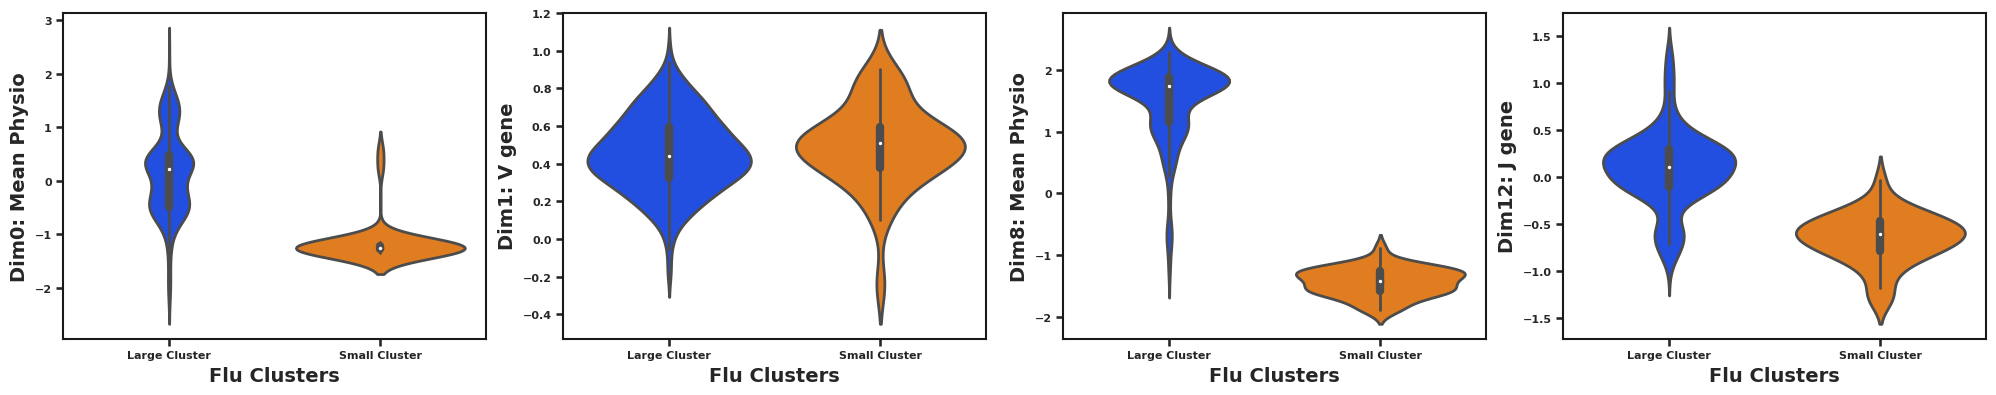

In [101]:
fig, axes = plt.subplots(1, 4, figsize=(20,4)) 
sns.violinplot(data=frames_for_plot,y="dim0",x="Flu_Clusters",ax=axes[0])
axes[0].set_ylabel('Dim0: Mean Physio', fontsize=14)
axes[0].set_xlabel('Flu Clusters', fontsize=14)

sns.violinplot(data=frames_for_plot,y="dim1",x="Flu_Clusters",ax=axes[1])
axes[1].set_ylabel('Dim1: V gene', fontsize=14)
axes[1].set_xlabel('Flu Clusters', fontsize=14)

sns.violinplot(data=frames_for_plot,y="dim8",x="Flu_Clusters",ax=axes[2])
axes[2].set_ylabel('Dim8: Mean Physio', fontsize=14)
axes[2].set_xlabel('Flu Clusters', fontsize=14)

sns.violinplot(data=frames_for_plot,y="dim12",x="Flu_Clusters",ax=axes[3])
axes[3].set_ylabel('Dim12: J gene', fontsize=14)
axes[3].set_xlabel('Flu Clusters', fontsize=14)
fig.tight_layout()

#fig.savefig('/data/home/allen.leary/tcrvalid_figs/Disintangled_Flu_Dims.pdf')  

## Now take a look at the decoded TCRs at the mean position of each cluster
#### Convert physicochemical map created by decoder into a position weight matrix (PWM)

In [93]:
def inv_manhattan(x,y):
  return (1.0/(pairwise.manhattan_distances(x,y) + 1e-6))

In [94]:
probs_LRG = mapping.array_to_probs(large_flu_average,inv_manhattan)
probs_SML = mapping.array_to_probs(small_flu_average,inv_manhattan)

(1, 28, 22)
(28, 22)
(1, 28, 22)
(28, 22)


In [103]:
def save_pdf(pdf_bytes, path):
  with open(path, "wb") as binary_file:
      binary_file.write(pdf_bytes)
  return None

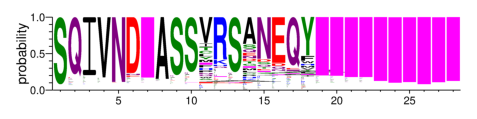

In [104]:
myfigsize=(15.0/2.54, 12./2.54)

fpca, pca_pdf = logo_from_probs(probs_LRG[0,:,:],mapping,color_scheme='chemistry',units='probability',return_pdf=True,figsize=myfigsize)
#save_pdf(pca_pdf, '/data/home/allen.leary/tcrvalid_figs/LRG_Flu_Logo.pdf')


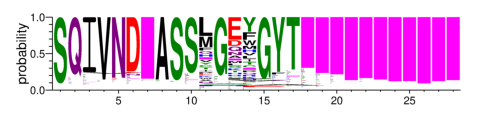

In [106]:
fpca, pca_pdf = logo_from_probs(probs_SML[0,:,:],mapping,color_scheme='chemistry',units='probability',return_pdf=True,figsize=myfigsize)
#save_pdf(pca_pdf, '/data/home/allen.leary/tcrvalid_figs/SML_Flu_Logo.pdf')